In [1]:
from transformers import AutoTokenizer, AutoModel
import senteval
import torch
import torch.nn as nn
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader, Dataset
import gzip
import csv

sts_dataset_path = '../datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

texts = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        if row['split'] == 'test':
            texts.append(row['sentence1'])
            texts.append(row['sentence2'])

class BaseDataset(Dataset):
    def __init__(self, texts, scale=None):
        # samples in format [[sentences1], [sentences2], [scores or labels]]
        # scores range is [0, 5], labels are strings
        self.texts = []
        for t in texts:
            self.texts.append(t)

    def __getitem__(self, idx):
        return self.texts[idx]

    def __len__(self):
        return len(self.texts)

dataset = BaseDataset(texts)
loader = DataLoader(dataset, batch_size=128)

2024-06-12 00:48:44.586911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 00:48:44.586938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 00:48:44.586964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 00:48:44.592370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# taken from https://github.com/google-research/google-research/blob/master/representation_similarity/Demo.ipynb

import numpy as np

def gram_linear(x):
    """Compute Gram (kernel) matrix for a linear kernel.

    Args:
    x: A num_examples x num_features matrix of features.

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
    """Compute Gram (kernel) matrix for an RBF kernel.

    Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
        bandwidth. (This is the heuristic we use in the paper. There are other
        possible ways to set the bandwidth; we didn't try them.)

    Returns:
    A num_examples x num_examples Gram matrix of examples.
    """
    dot_products = x.dot(x.T)
    sq_norms = np.diag(dot_products)
    sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
    sq_median_distance = np.median(sq_distances)
    return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
    """Center a symmetric Gram matrix.

    This is equvialent to centering the (possibly infinite-dimensional) features
    induced by the kernel before computing the Gram matrix.

    Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
        estimate of HSIC. Note that this estimator may be negative.

    Returns:
    A symmetric matrix with centered columns and rows.
    """
    if not np.allclose(gram, gram.T):
        raise ValueError('Input must be a symmetric matrix.')
    gram = gram.copy()

    if unbiased:
        # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
        # L. (2014). Partial distance correlation with methods for dissimilarities.
        # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
        # stable than the alternative from Song et al. (2007).
        n = gram.shape[0]
        np.fill_diagonal(gram, 0)
        means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
        means -= np.sum(means) / (2 * (n - 1))
        gram -= means[:, None]
        gram -= means[None, :]
        np.fill_diagonal(gram, 0)
    else:
        means = np.mean(gram, 0, dtype=np.float64)
        means -= np.mean(means) / 2
        gram -= means[:, None]
        gram -= means[None, :]

    return gram


def cka(gram_x, gram_y, debiased=False):
    """Compute CKA.

    Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

    Returns:
    The value of CKA between X and Y.
    """
    gram_x = center_gram(gram_x, unbiased=debiased)
    gram_y = center_gram(gram_y, unbiased=debiased)

    # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
    # n*(n-3) (unbiased variant), but this cancels for CKA.
    scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

    normalization_x = np.linalg.norm(gram_x)
    normalization_y = np.linalg.norm(gram_y)
    return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y, n):
    """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
    # This formula can be derived by manipulating the unbiased estimator from
    # Song et al. (2007).
    return (xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
    """Compute CKA with a linear kernel, in feature space.

    This is typically faster than computing the Gram matrix when there are fewer
    features than examples.

    Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
        biased. Note that this estimator may be negative.

    Returns:
    The value of CKA between X and Y.
    """
    features_x = features_x - np.mean(features_x, 0, keepdims=True)
    features_y = features_y - np.mean(features_y, 0, keepdims=True)

    dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
    normalization_x = np.linalg.norm(features_x.T.dot(features_x))
    normalization_y = np.linalg.norm(features_y.T.dot(features_y))

    if debiased:
        n = features_x.shape[0]
        # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
        sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
        sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
        squared_norm_x = np.sum(sum_squared_rows_x)
        squared_norm_y = np.sum(sum_squared_rows_y)

        dot_product_similarity = _debiased_dot_product_similarity_helper(
            dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
            squared_norm_x, squared_norm_y, n)
        normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
            squared_norm_x, squared_norm_x, n))
        normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
            normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
            squared_norm_y, squared_norm_y, n))

    return dot_product_similarity / (normalization_x * normalization_y)

In [4]:
DEVICE = "cuda:0"

def batch_to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}
    
class MeanPooling(nn.Module):
    def __init__(self, starting_state):
        super().__init__()
        self.starting_state = starting_state

    def forward(self, x, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float().to(DEVICE)
        emb_sum = torch.sum(x * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9) # denominator
        emb_mean = emb_sum / sum_mask
        return emb_mean
    
class GenericModel:

    def __init__(self, model_name, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if path is None:
            self.model = AutoModel.from_pretrained(model_name).to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
        self.model.eval()
    
    @torch.no_grad()
    def forward(self, loader):
        activations = []
        for _, t in tqdm(enumerate(loader)):
            tokenized = self.tokenizer(t, padding=True, truncation=True, return_tensors="pt")

            tokenized_device = batch_to_device(tokenized, DEVICE)

            out = self.model(**tokenized_device, output_hidden_states=True).hidden_states[self.pooling.starting_state]
            out_mean = self.pooling(out, tokenized_device["attention_mask"])
            
            activations.append(out_mean)
            
        return torch.cat(activations, dim=0).detach().cpu().numpy()

# Calculating activations

In [5]:
models_electra = [
    "model_2024_06_02_21_23_18_stsb",
    "model_2024_06_02_21_53_27_stsb",
    "model_2024_06_02_22_26_42_stsb",
    "model_2024_06_02_23_03_24_stsb",
    "model_2024_06_02_23_44_17_stsb",
    "model_2024_06_03_00_29_11_stsb",
    "model_2024_06_03_01_18_02_stsb",
    "model_2024_06_03_02_10_39_stsb",
    "model_2024_06_03_03_06_35_stsb",
    "model_2024_06_03_04_06_06_stsb",
    "model_2024_06_03_05_08_52_stsb",
    "model_2024_06_03_06_14_58_stsb",
    "model_2024_06_03_07_24_29_stsb",
]

def get_activations(models, model_name, skip_path=False):
    activations = []
    for i, m in enumerate(models):
        curr_model = GenericModel(
            starting_state=i, 
            model_name=model_name,
            path=None if skip_path else f"../output/{model_name.replace('/','-')}/mean/{i}_to_{i+1}/{m}.pt",
        )
        act_i = curr_model.forward(loader)
        activations.append(act_i)
    return np.array(activations)

activations_electra = get_activations(models_electra, "google/electra-base-discriminator")
activations_electra_pretrained = get_activations(models_electra, "google/electra-base-discriminator", True)
    
print(len(activations_electra), activations_electra[0].shape)
print(len(activations_electra_pretrained), activations_electra_pretrained[0].shape)

/home/irep/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
22it [00:02,  9.67it/s]
22it [00:02, 10.16it/s]
22it [00:02, 10.10it/s]
22it [00:02, 10.07it/s]
22it [00:02, 10.07it/s]
22it [00:02, 10.06it/s]
22it [00:02, 10.06it/s]
22it [00:02, 10.04it/s]
22it [00:02, 10.03it/s]
22it [00:02, 10.04it/s]
22it [00:02, 10.03it/s]
22it [00:02, 10.02it/s]
22it [00:02, 10.03it/s]
/home/irep/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)(

13 (2758, 768)
13 (2758, 768)


In [6]:
models_bert = [
    "model_2024_06_02_21_33_44_stsb",
    "model_2024_06_02_22_05_08_stsb",
    "model_2024_06_02_22_39_46_stsb",
    "model_2024_06_02_23_18_33_stsb",
    "model_2024_06_03_00_01_25_stsb",
    "model_2024_06_03_00_48_11_stsb",
    "model_2024_06_03_01_38_30_stsb",
    "model_2024_06_03_02_32_23_stsb",
    "model_2024_06_03_03_29_45_stsb",
    "model_2024_06_03_04_30_33_stsb",
    "model_2024_06_03_05_34_41_stsb",
    "model_2024_06_03_06_42_05_stsb",
    "model_2024_06_03_07_52_58_stsb",
]

activations_bert = get_activations(models_bert, "bert-base-cased")
activations_bert_pretrained = get_activations(models_bert, "bert-base-cased", True)
    
print(len(activations_bert), activations_bert[0].shape)
print(len(activations_bert_pretrained), activations_bert_pretrained[0].shape)

22it [00:02,  9.71it/s]
22it [00:02,  9.67it/s]
22it [00:02,  9.71it/s]
22it [00:02,  9.71it/s]
22it [00:02,  9.70it/s]
22it [00:02,  9.70it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.70it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.70it/s]
22it [00:02,  9.67it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.71it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.70it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.23it/s]
22it [00:02,  9.67it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.68it/s]


13 (2758, 768)
13 (2758, 768)


In [7]:
models_electra_gen = [
    "model_2024_06_02_21_29_21_stsb",
    "model_2024_06_02_22_00_12_stsb",
    "model_2024_06_02_22_34_12_stsb",
    "model_2024_06_02_23_11_44_stsb",
    "model_2024_06_02_23_53_33_stsb",
    "model_2024_06_03_00_39_17_stsb",
    "model_2024_06_03_01_28_54_stsb",
    "model_2024_06_03_02_22_15_stsb",
    "model_2024_06_03_03_18_57_stsb",
    "model_2024_06_03_04_19_12_stsb",
    "model_2024_06_03_05_22_42_stsb",
    "model_2024_06_03_06_29_33_stsb",
    "model_2024_06_03_07_39_51_stsb",
]

activations_electra_gen = get_activations(models_electra_gen, "google/electra-base-generator")
activations_electra_gen_pretrained = get_activations(models_electra_gen, "google/electra-base-generator", True)
    
print(len(activations_electra_gen), activations_electra_gen[0].shape)
print(len(activations_electra_gen_pretrained), activations_electra_gen_pretrained[0].shape)

22it [00:00, 53.34it/s]
22it [00:00, 54.12it/s]
22it [00:00, 54.47it/s]
22it [00:00, 54.46it/s]
22it [00:00, 54.44it/s]
22it [00:00, 54.25it/s]
22it [00:00, 54.48it/s]
22it [00:00, 54.52it/s]
22it [00:00, 54.58it/s]
22it [00:00, 54.43it/s]
22it [00:00, 54.51it/s]
22it [00:00, 54.41it/s]
22it [00:00, 54.56it/s]
22it [00:00, 54.54it/s]
22it [00:00, 54.43it/s]
22it [00:00, 54.67it/s]
22it [00:00, 54.51it/s]
22it [00:00, 54.55it/s]
22it [00:00, 54.50it/s]
22it [00:00, 38.59it/s]
22it [00:00, 54.68it/s]
22it [00:00, 54.57it/s]
22it [00:00, 54.53it/s]
22it [00:00, 53.48it/s]
22it [00:00, 54.60it/s]
22it [00:00, 54.52it/s]

13 (2758, 256)
13 (2758, 256)


In [8]:
models_deberta_disc = [
    "model_2024_06_02_21_12_47_stsb",
    "model_2024_06_02_21_41_45_stsb",
    "model_2024_06_02_22_14_00_stsb",
    "model_2024_06_02_22_49_31_stsb",
    "model_2024_06_02_23_29_12_stsb",
    "model_2024_06_03_00_12_57_stsb",
    "model_2024_06_03_01_00_37_stsb",
    "model_2024_06_03_01_51_54_stsb",
    "model_2024_06_03_02_46_43_stsb",
    "model_2024_06_03_03_45_01_stsb",
    "model_2024_06_03_04_46_41_stsb",
    "model_2024_06_03_05_51_43_stsb",
    "model_2024_06_03_07_00_04_stsb",
    ]

activations_deberta_disc = get_activations(models_deberta_disc, "microsoft/deberta-v3-base")
activations_deberta_disc_pretrained = get_activations(models_deberta_disc, "microsoft/deberta-v3-base", True)
    
print(len(activations_deberta_disc), activations_deberta_disc[0].shape)
print(len(activations_deberta_disc_pretrained), activations_deberta_disc_pretrained[0].shape)

/home/irep/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:03,  5.88it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:03,  5.85it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum leng

13 (2758, 768)
13 (2758, 768)


In [9]:
activations_roberta_pretrained = get_activations(models_deberta_disc, "FacebookAI/roberta-base", True)
    
print(len(activations_roberta_pretrained), activations_roberta_pretrained[0].shape)

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
22it [00:02, 10.33it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
22it [00:02, 10.26it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
22it [00:02, 10.25it/s]
Some weights of Robert

13 (2758, 768)


In [10]:
activations_xlnet_pretrained = get_activations(models_deberta_disc, "xlnet/xlnet-base-cased", True)
    
print(len(activations_xlnet_pretrained), activations_xlnet_pretrained[0].shape)

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:03,  7.33it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:03,  7.33it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:02,  7.34it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:02,  7.33it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
22it [00:03,  7.31it/s]
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided 

13 (2758, 768)


In [11]:
activations_albert_pretrained = get_activations(models_deberta_disc, "albert/albert-base-v2", True)
    
print(len(activations_albert_pretrained), activations_albert_pretrained[0].shape)

22it [00:02,  7.74it/s]
22it [00:02,  7.70it/s]
22it [00:02,  7.66it/s]
22it [00:02,  7.74it/s]
22it [00:02,  7.76it/s]
22it [00:02,  7.73it/s]
22it [00:02,  7.75it/s]
22it [00:02,  7.76it/s]
22it [00:02,  7.77it/s]
22it [00:02,  7.72it/s]
22it [00:02,  7.69it/s]
22it [00:02,  7.74it/s]
22it [00:02,  7.75it/s]

13 (2758, 768)


In [12]:
activations_deberta_pretrained = get_activations(models_deberta_disc, "microsoft/deberta-base", True)
    
print(len(activations_deberta_pretrained), activations_deberta_pretrained[0].shape)

22it [00:02,  7.70it/s]
22it [00:02,  7.67it/s]
22it [00:02,  7.69it/s]
22it [00:02,  7.62it/s]
22it [00:02,  7.71it/s]
22it [00:02,  7.71it/s]
22it [00:02,  7.65it/s]
22it [00:02,  7.73it/s]
22it [00:02,  7.91it/s]
22it [00:02,  7.63it/s]
22it [00:02,  7.72it/s]
22it [00:02,  7.72it/s]
22it [00:02,  7.44it/s]

13 (2758, 768)


# ELECTRA discriminator VS BERT

In [13]:
def do_cka_on_diag(model_acts1, model_acts2, rbf_val=None):
    cka_values = []
    for i in tqdm(range(len(model_acts1))):
        m1 = model_acts1[i]
        m2 = model_acts2[i]
        if rbf_val is not None:
            cka_values.append(cka(gram_rbf(m1, rbf_val), gram_rbf(m2, rbf_val)))
        else:
            cka_values.append(cka(gram_linear(m1), gram_linear(m2)))

    return cka_values

def plot_diag(diags, labels, model_name1, model_name2, xlabel="Layer index", ylabel="CKA coefficient value"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_facecolor("#F9F9F9")
    ax.grid(color='black', linestyle=(0, (1, 5)), linewidth=0.5)
    for d, l in zip(diags, labels):
        ax.plot(d, "-o", label=l)
    plt.legend()
    ax.set_title(f"{model_name1} and {model_name2}")
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.32it/s]


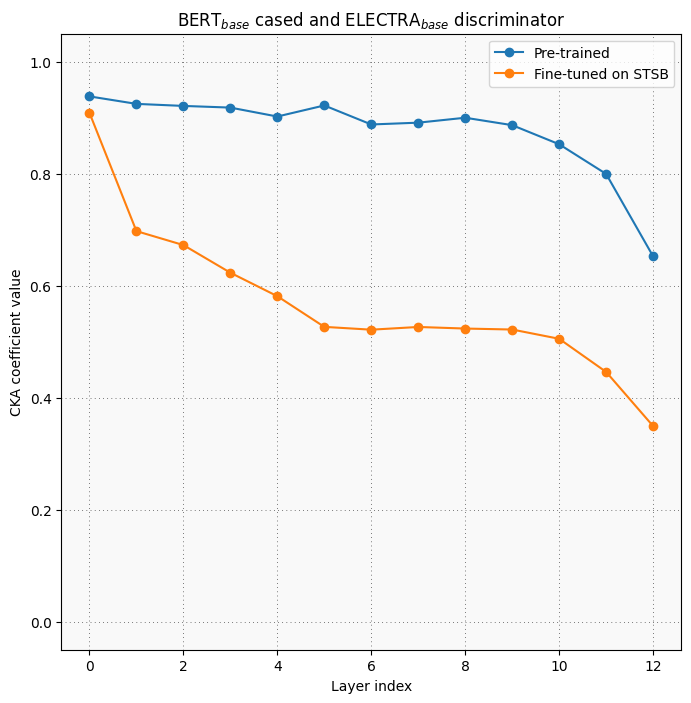

In [22]:
diag = do_cka_on_diag(activations_electra, activations_bert)
diag_pretrained = do_cka_on_diag(activations_electra_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag_pretrained, diag],
    labels=[
        "Pre-trained",
        "Fine-tuned on STSB"
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="ELECTRA$_{base}$ discriminator",
)
plt.savefig("./plots/electra_disc_bert.pdf", format="pdf", bbox_inches="tight", dpi=300)

# ELECTRA generator VS BERT

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.60it/s]


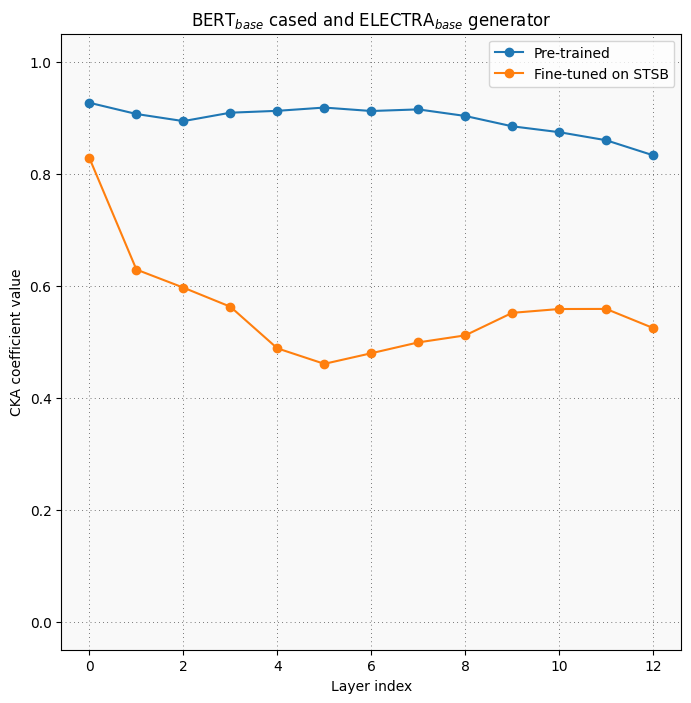

In [23]:
diag = do_cka_on_diag(activations_electra_gen, activations_bert)
diag_pretrained = do_cka_on_diag(activations_electra_gen_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag_pretrained, diag],
    labels=[
        "Pre-trained",
        "Fine-tuned on STSB"
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="ELECTRA$_{base}$ generator",
)
plt.savefig("./plots/electra_gen_bert.pdf", format="pdf", bbox_inches="tight", dpi=300)

# DeBERTa discriminator VS BERT

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.42it/s]


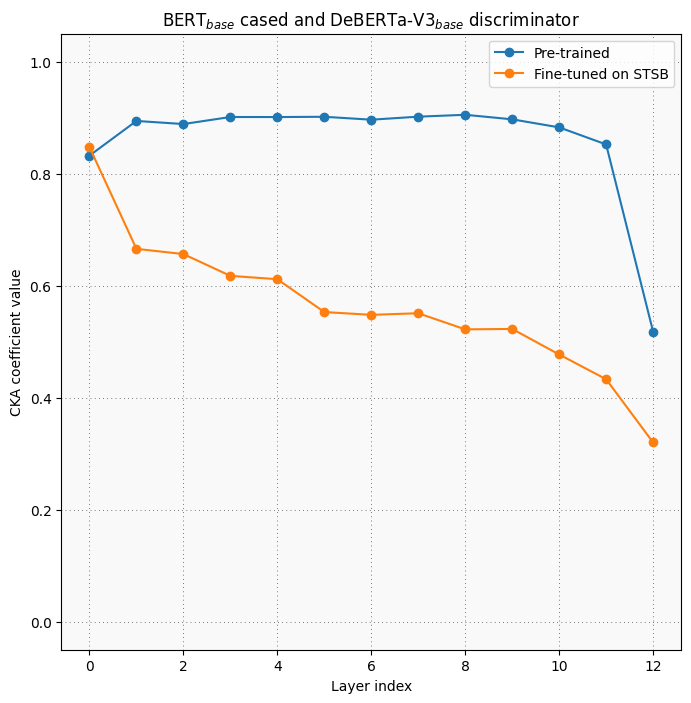

In [24]:
diag = do_cka_on_diag(activations_deberta_disc, activations_bert)
diag_pretrained = do_cka_on_diag(activations_deberta_disc_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag_pretrained, diag],
    labels=[
        "Pre-trained",
        "Fine-tuned on STSB"
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="DeBERTa-V3$_{base}$ discriminator",
)
plt.savefig("./plots/deberta_disc_bert.pdf", format="pdf", bbox_inches="tight", dpi=300)

# Others VS BERT

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.15it/s]


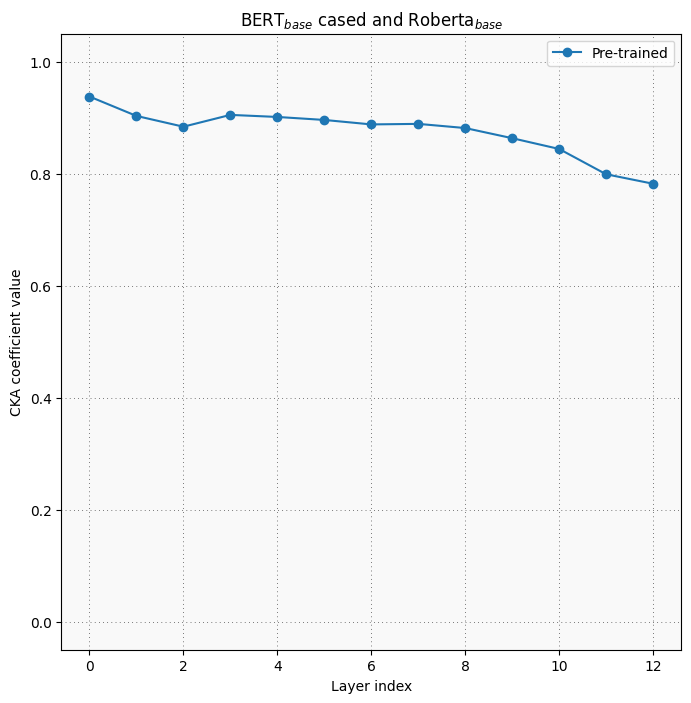

In [17]:
diag = do_cka_on_diag(activations_roberta_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag,],
    labels=[
        "Pre-trained",
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="Roberta$_{base}$",
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


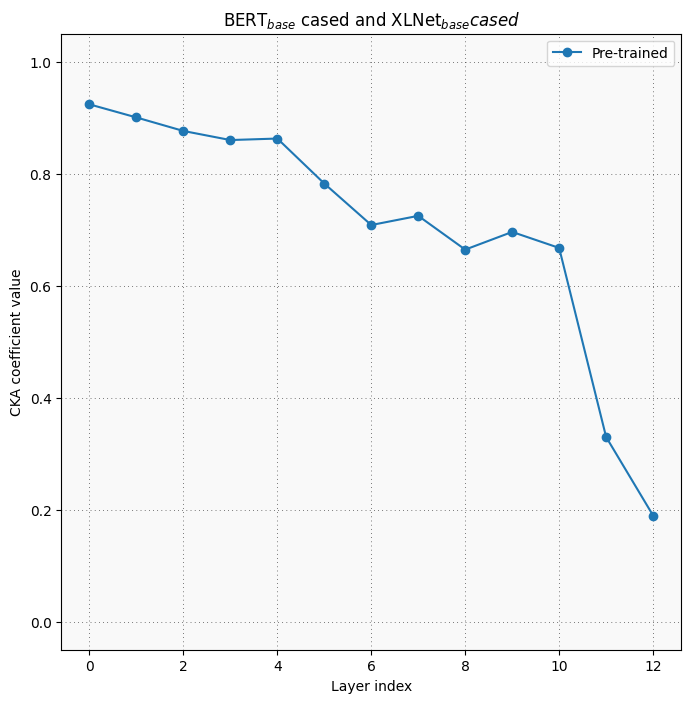

In [18]:
diag = do_cka_on_diag(activations_xlnet_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag,],
    labels=[
        "Pre-trained",
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="XLNet$_{base} cased$",
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.12it/s]


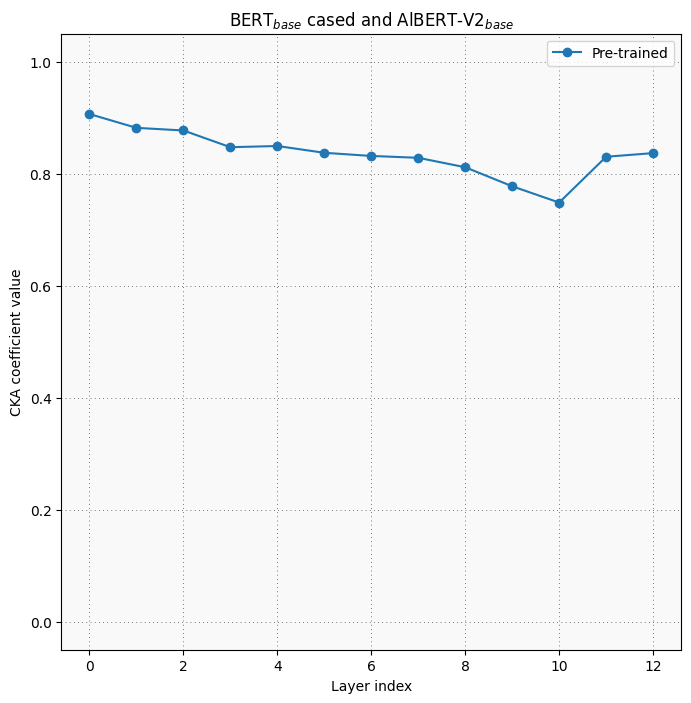

In [19]:
diag = do_cka_on_diag(activations_albert_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag,],
    labels=[
        "Pre-trained",
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="AlBERT-V2$_{base}$",
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


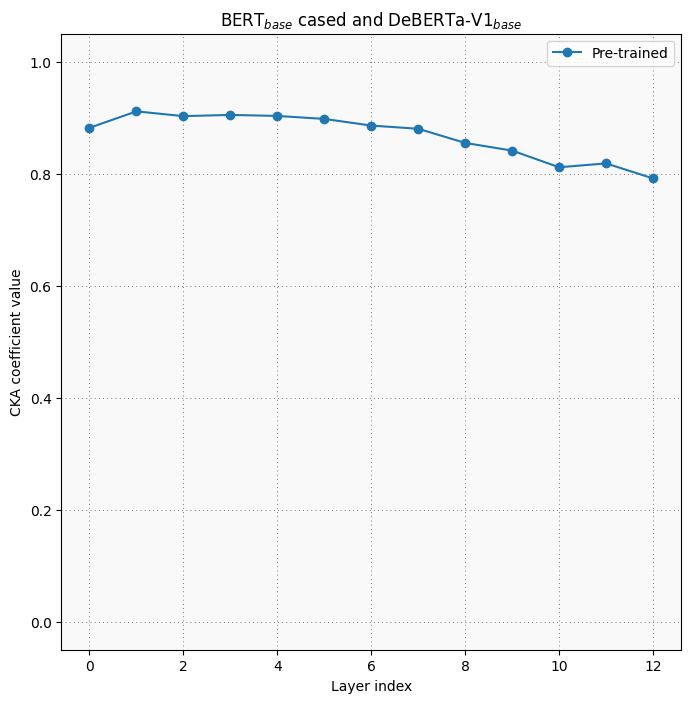

In [20]:
diag = do_cka_on_diag(activations_deberta_pretrained, activations_bert_pretrained)

plot_diag(
    diags=[diag,],
    labels=[
        "Pre-trained",
    ],
    model_name1="BERT$_{base}$ cased",
    model_name2="DeBERTa-V1$_{base}$",
)

In [8]:
import matplotlib.pyplot as plt

def plot_heatmap_cka(model_acts1, model_acts2, x_label, y_label, rbf_val=0.4):
    linear_heatmap = np.random.random((len(model_acts1), len(model_acts2)))
    #rbf_heatmap = np.random.random((len(model_acts1), len(model_acts2)))
    for i, m1 in tqdm(enumerate(model_acts1)):
        for j, m2 in enumerate(model_acts2):
            linear_heatmap[i][j] = cka(gram_linear(m1), gram_linear(m2))
            #rbf_heatmap[i][j] = cka(gram_rbf(m1, rbf_val), gram_rbf(m2, rbf_val))


    plt.title("CKA using a linear kernel")
    plt.xlabel(f"Hidden layer of {x_label}")
    plt.ylabel(f"Hidden layer of {y_label}")
    tmp = plt.imshow(linear_heatmap)#, vmin=0, vmax=1)
    ax = tmp.axes
    ax.invert_yaxis()
    plt.colorbar()
    plt.show()
    
    return [linear_heatmap[i][i] for i in range(len(linear_heatmap))]
    
    #plt.title(f"CKA using an RBF kernel with value {rbf_val}")
    #plt.xlabel(f"Hidden layer of {x_label}")
    #plt.ylabel(f"Hidden layer of {y_label}")
    #tmp = plt.imshow(rbf_heatmap, vmin=0, vmax=1)
    #ax = tmp.axes
    #ax.invert_yaxis()
    #plt.colorbar()
    #plt.show()


13it [00:29,  2.23s/it]


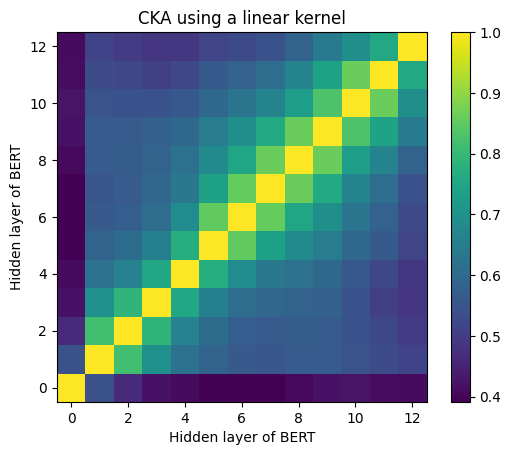

In [10]:
diag = plot_heatmap_cka(bert_activations_np, bert_activations_np, "BERT", "BERT")

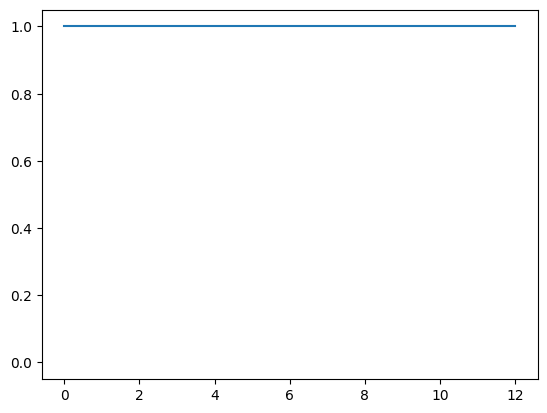

In [11]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:29,  2.29s/it]


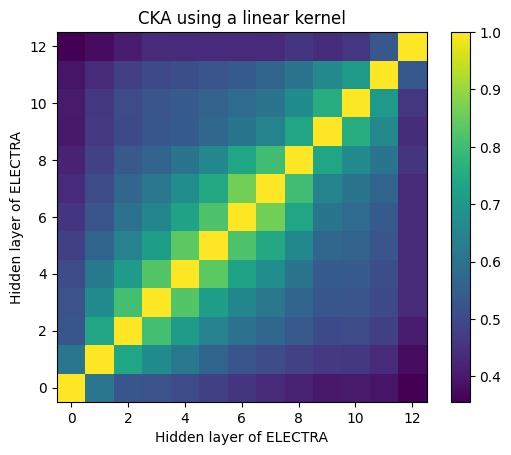

In [12]:
diag = plot_heatmap_cka(electra_activations_np, electra_activations_np, "ELECTRA", "ELECTRA")

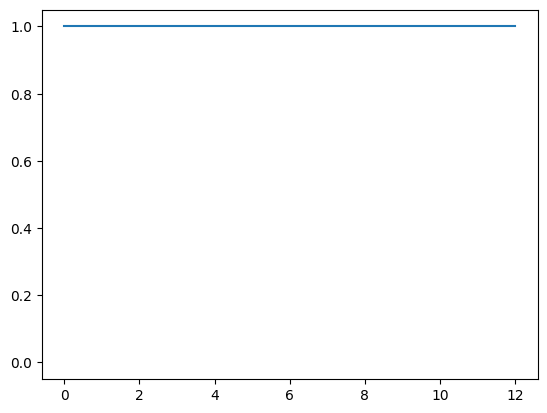

In [13]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:27,  2.08s/it]


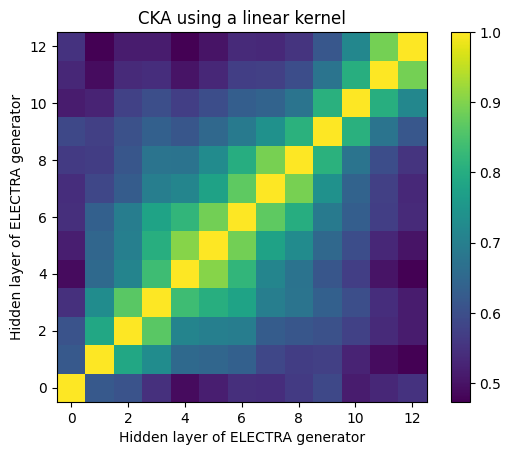

In [14]:
diag = plot_heatmap_cka(electra_activations_gen_np, electra_activations_gen_np, "ELECTRA generator", "ELECTRA generator")

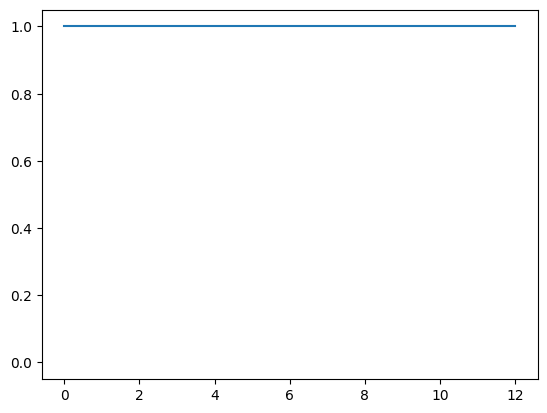

In [15]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:27,  2.15s/it]


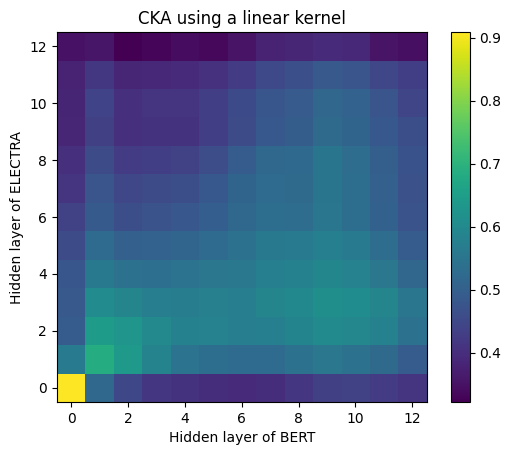

In [16]:
diag = plot_heatmap_cka(electra_activations_np, bert_activations_np, "BERT", "ELECTRA")

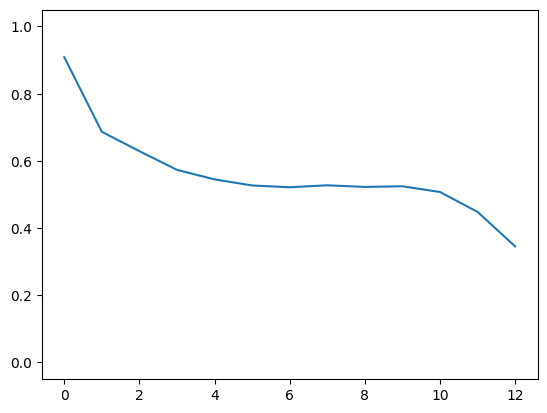

In [17]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:27,  2.09s/it]


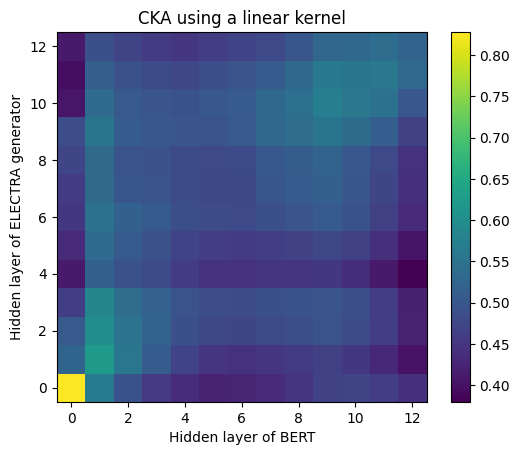

In [18]:
diag = plot_heatmap_cka(electra_activations_gen_np, bert_activations_np, "BERT", "ELECTRA generator")

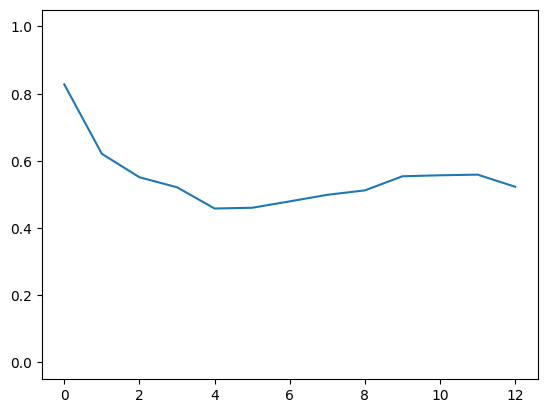

In [19]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

In [5]:
activations_bert = []
for i in range(13):
    bert = Bert(starting_state=i)
    act_i = bert.forward(loader)
    activations_bert.append(act_i)
    
print(len(activations_bert), activations_bert[0].shape)

22it [00:02,  8.93it/s]
22it [00:02,  9.68it/s]
22it [00:02,  9.80it/s]
22it [00:02,  9.79it/s]
22it [00:02,  9.48it/s]
22it [00:02,  9.61it/s]
22it [00:02,  9.43it/s]
22it [00:02,  9.76it/s]
22it [00:02,  9.76it/s]
22it [00:02,  9.44it/s]
22it [00:02,  9.51it/s]
22it [00:02,  9.69it/s]
22it [00:02,  9.85it/s]

13 (2758, 768)


In [6]:
activations_electra = []
for i in range(13):
    electra = Electra(starting_state=i)
    act_i = electra.forward(loader)
    activations_electra.append(act_i)
    
print(len(activations_electra), activations_electra[0].shape)

/home/irep/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
22it [00:02,  9.37it/s]
22it [00:02,  9.65it/s]
22it [00:02,  9.48it/s]
22it [00:02,  9.49it/s]
22it [00:02,  9.58it/s]
22it [00:02,  9.55it/s]
22it [00:02,  9.09it/s]
22it [00:02,  9.26it/s]
22it [00:02,  9.50it/s]
22it [00:02,  9.59it/s]
22it [00:02,  9.56it/s]
22it [00:02,  9.45it/s]
22it [00:02,  9.49it/s]

13 (2758, 768)


In [ ]:
activations_electra_gen = []
for i in range(13):
    electra_gen = ElectraGenerator(starting_state=i)
    act_i = electra_gen.forward(loader)
    activations_electra_gen.append(act_i)
    
print(len(activations_electra_gen), activations_electra_gen[0].shape)

In [10]:
electra_activations_np = np.array(activations_electra)
bert_activations_np = np.array(activations_bert)
electra_activations_gen_np = np.array(activations_electra_gen)

electra_activations_gen_np.shape, electra_activations_np.shape, bert_activations_np.shape

NameError: name 'activations_electra_gen' is not defined

13it [00:30,  2.35s/it]


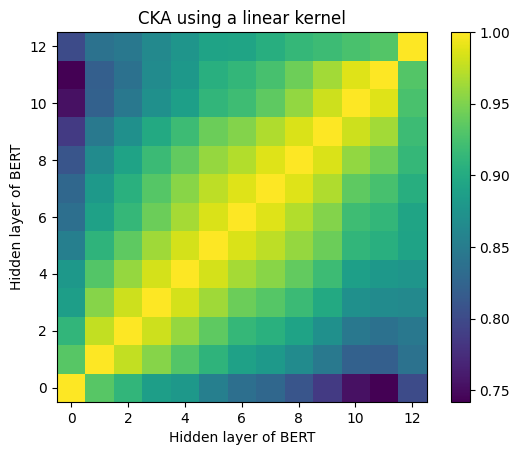

In [24]:
diag = plot_heatmap_cka(bert_activations_np, bert_activations_np, "BERT", "BERT")

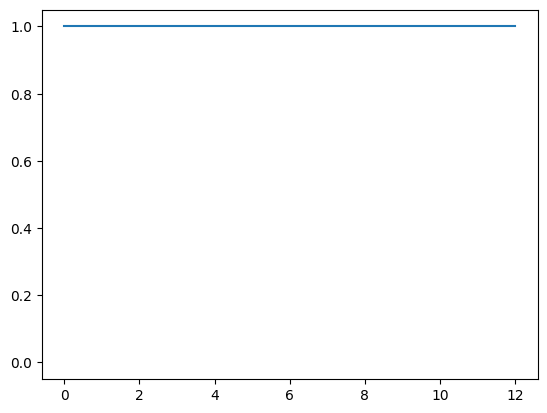

In [25]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:30,  2.36s/it]


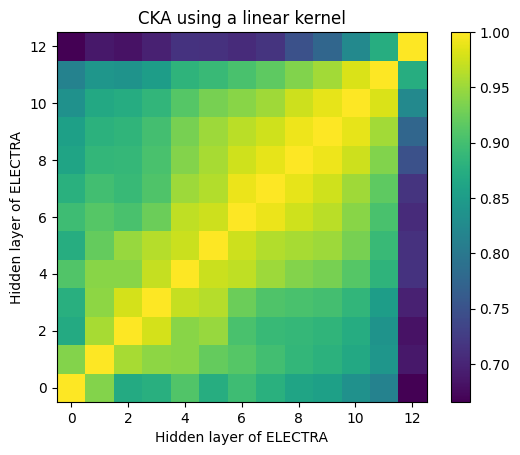

In [26]:
diag = plot_heatmap_cka(electra_activations_np, electra_activations_np, "ELECTRA", "ELECTRA")

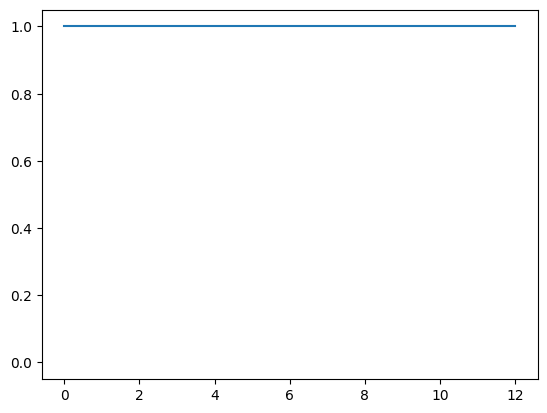

In [27]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:28,  2.19s/it]


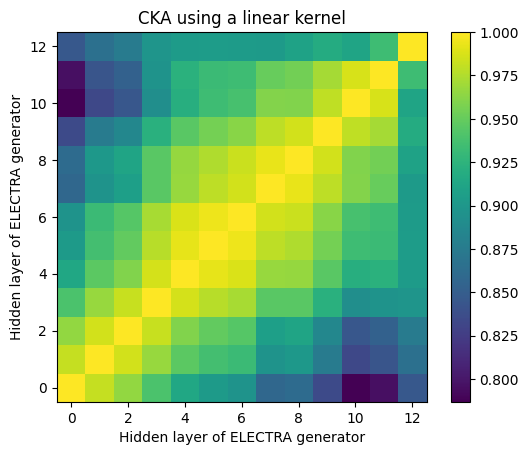

In [28]:
diag = plot_heatmap_cka(electra_activations_gen_np, electra_activations_gen_np, "ELECTRA generator", "ELECTRA generator")

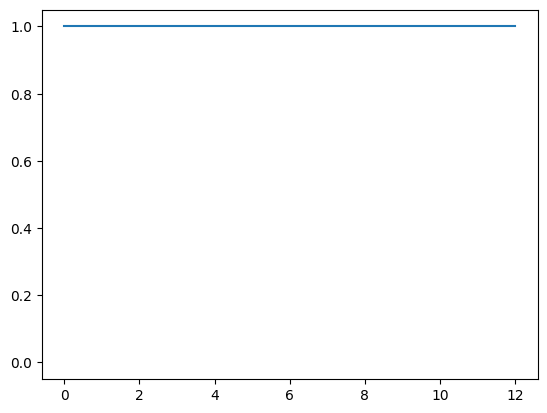

In [29]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:29,  2.27s/it]


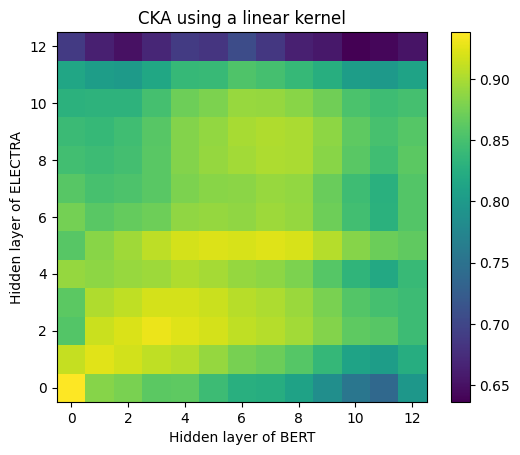

In [30]:
diag = plot_heatmap_cka(electra_activations_np, bert_activations_np, "BERT", "ELECTRA")

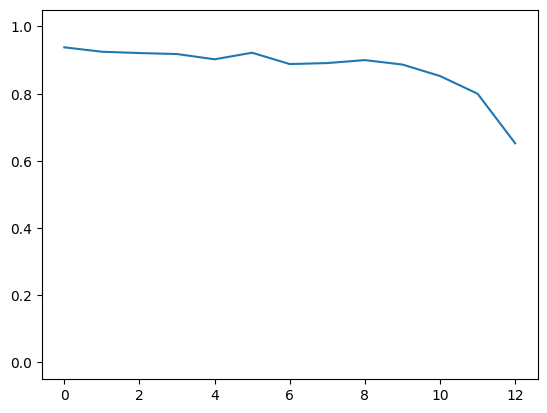

In [31]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

13it [00:28,  2.19s/it]


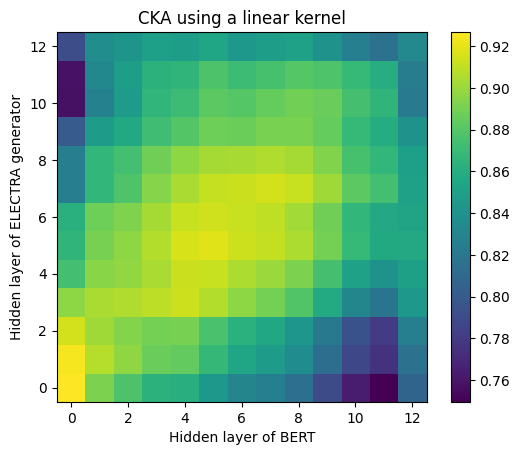

In [32]:
diag = plot_heatmap_cka(electra_activations_gen_np, bert_activations_np, "BERT", "ELECTRA generator")

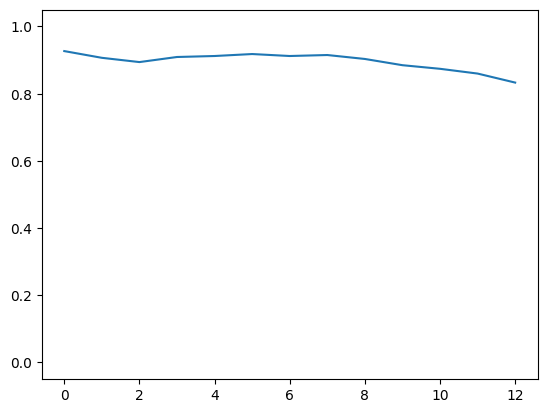

In [33]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)

In [7]:
activations_electra = []
for i in range(13):
    electra = Electra(path="../dapt/google-electra-base-discriminator/model_epoch_9_mlm.p", starting_state=i)
    act_i = electra.forward(loader)
    activations_electra.append(act_i)
    
print(len(activations_electra), activations_electra[0].shape)

22it [00:02,  9.68it/s]
22it [00:02,  9.61it/s]
22it [00:02,  9.54it/s]
22it [00:02,  9.63it/s]
22it [00:02,  9.64it/s]
22it [00:02,  9.49it/s]
22it [00:02,  9.58it/s]
22it [00:02,  9.44it/s]
22it [00:02,  9.59it/s]
22it [00:02,  9.44it/s]
22it [00:02,  9.58it/s]
22it [00:02,  9.41it/s]
22it [00:02,  9.50it/s]

13 (2758, 768)


In [11]:
electra_activations_np = np.array(activations_electra)
bert_activations_np = np.array(activations_bert)

electra_activations_np.shape, bert_activations_np.shape

((13, 2758, 768), (13, 2758, 768))

13it [00:30,  2.33s/it]


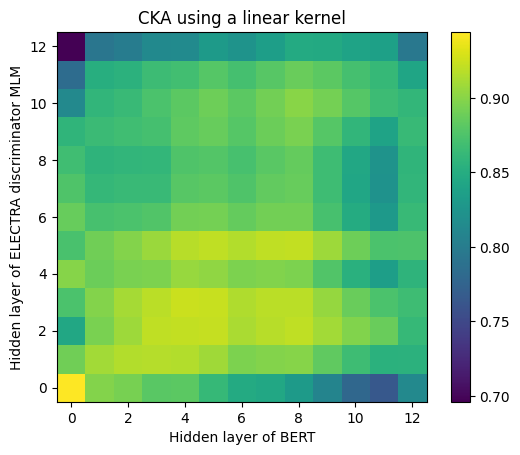

In [12]:
diag = plot_heatmap_cka(activations_electra, bert_activations_np, "BERT", "ELECTRA discriminator MLM")

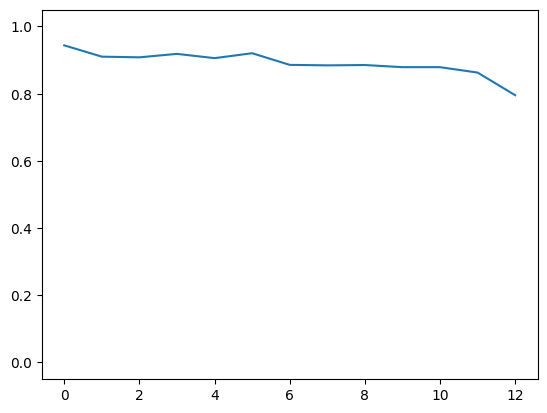

In [13]:
diag = np.array(diag).astype(np.float16)
plt.ylim([-0.05, 1.05])
plt.plot(diag)